In [47]:
# Importar librerías
import os
import cv2
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Función para redimensionar y normalizar imágenes
def preprocess_images(image_sequences, target_height, target_width):
    preprocessed_sequences = []
    for sequence in image_sequences:
        processed_sequence = []
        for image in sequence:
            resized_image = cv2.resize(image, (target_width, target_height))  # Redimensionar
            normalized_image = resized_image / 255.0  # Normalizar entre 0 y 1
            processed_sequence.append(normalized_image)
        preprocessed_sequences.append(processed_sequence)
    return np.array(preprocessed_sequences)

# Configurar carpeta de imágenes
image_folder = "../data/Images_test/"

# Cargar imágenes (adaptar según estructura)
images = []
for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith(".jpg"):
        img = cv2.imread(os.path.join(image_folder, file_name))
        images.append(img)

# Convertir a numpy array y crear secuencias
images = np.array(images)
sequence_length = 5  # Longitud de la secuencia
X = [images[i:i + sequence_length] for i in range(len(images) - sequence_length)]
y = [images[i + sequence_length] for i in range(len(images) - sequence_length)]

X = np.array(X)
y = np.array(y)

# Preprocesar imágenes
X_preprocessed = preprocess_images(X, target_height=64, target_width=64)
y_preprocessed = preprocess_images(y, target_height=64, target_width=64)

print(f"X_preprocessed shape: {X_preprocessed.shape}")
print(f"y_preprocessed shape: {y_preprocessed.shape}")

# Dimensiones originales de la imagen
original_height, original_width, channels = 449, 593, 3

# Modelo de extracción de características
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Definir el modelo
model = Sequential()
model.add(TimeDistributed(feature_extractor, input_shape=(sequence_length, 64, 64, 3)))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(sequence_length * original_height * original_width * channels, activation="linear"))
model.add(Reshape((sequence_length, original_height, original_width, channels)))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")

# Entrenar el modelo
history = model.fit(X_preprocessed, y_preprocessed, epochs=10, batch_size=16, verbose=1)

print("Entrenamiento finalizado.")

# Realizar predicciones
y_pred = model.predict(X_preprocessed)

# Función para visualizar imágenes
def plot_images(images, title, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualizar resultados
plot_images(X[0], title="Secuencia de entrada (X)")
plot_images(y[0], title="Imágenes reales futuras (y)")
plot_images(y_pred[0], title="Imágenes futuras predichas (y_pred)")


X_preprocessed shape: (109, 5, 64, 64, 3)
y_preprocessed shape: (109, 449, 64, 64)


Epoch 1/10


ValueError: in user code:

    File "/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 1706, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 593 and 64 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_13/reshape_10/Reshape, IteratorGetNext:1)' with input shapes: [?,5,449,593,3], [?,449,64,64].


X_preprocessed shape: (109, 5, 64, 64, 3)
y_original shape: (109, 5, 449, 593, 3)


Epoch 1/10
7/7 [==============================] - 57s 7s/step - loss: 0.6446
Epoch 2/10
7/7 [==============================] - 44s 6s/step - loss: 0.6429
Epoch 3/10
7/7 [==============================] - 45s 6s/step - loss: 0.6375
Epoch 4/10
7/7 [==============================] - 45s 6s/step - loss: 0.6268
Epoch 5/10
7/7 [==============================] - 47s 7s/step - loss: 0.6094
Epoch 6/10
7/7 [==============================] - 53s 8s/step - loss: 0.5840
Epoch 7/10
7/7 [==============================] - 55s 8s/step - loss: 0.5508
Epoch 8/10
7/7 [==============================] - 48s 7s/step - loss: 0.5108
Epoch 9/10
7/7 [==============================] - 42s 6s/step - loss: 0.4659
Epoch 10/10
4/4 [==============================] - 4s 679ms/step


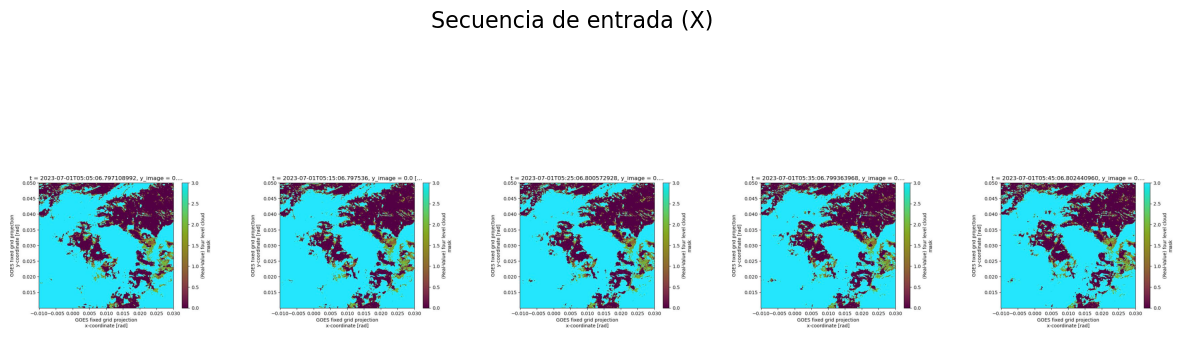

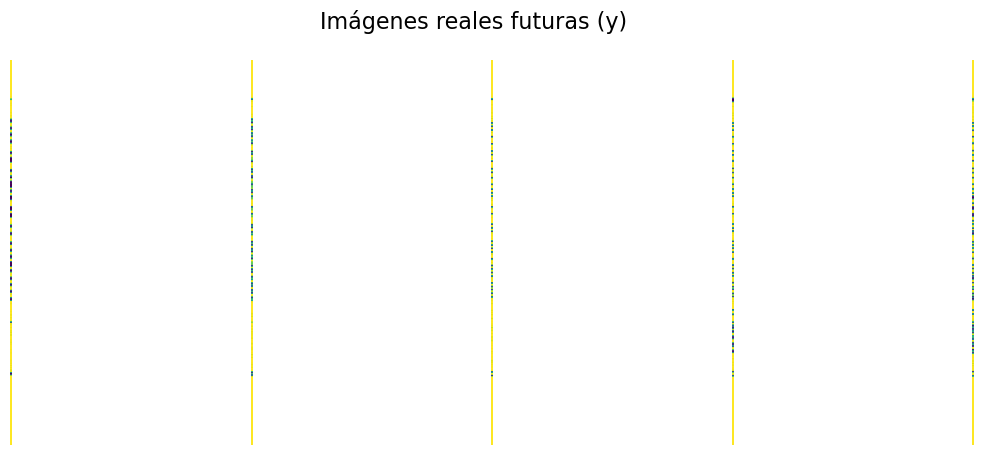

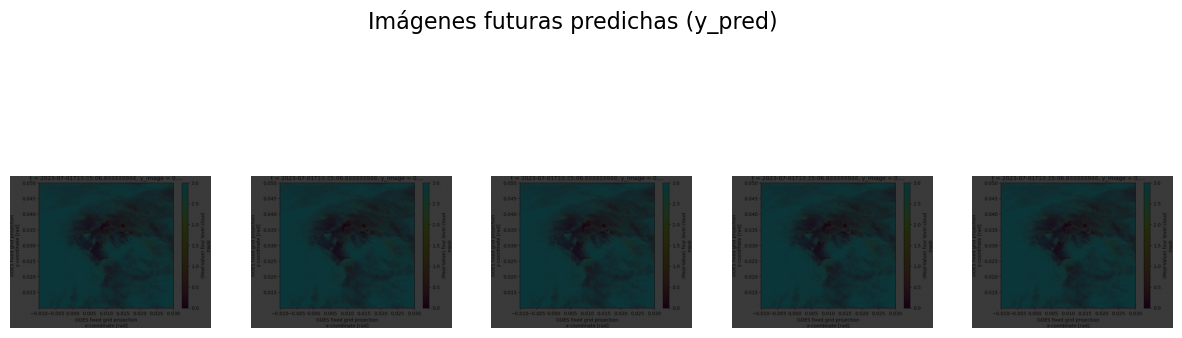

In [50]:
# Importar librerías
import os
import cv2
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Función para redimensionar y normalizar imágenes de entrada (X)
def preprocess_input_images(image_sequences, target_height, target_width):
    preprocessed_sequences = []
    for sequence in image_sequences:
        processed_sequence = []
        for image in sequence:
            resized_image = cv2.resize(image, (target_width, target_height))  # Redimensionar
            normalized_image = resized_image / 255.0  # Normalizar entre 0 y 1
            processed_sequence.append(normalized_image)
        preprocessed_sequences.append(processed_sequence)
    return np.array(preprocessed_sequences)

# Configurar carpeta de imágenes
image_folder = "../data/Images_test"  # Cambia esto a la ruta de tus imágenes

# Cargar imágenes
images = []
for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith(".jpg"):
        img = cv2.imread(os.path.join(image_folder, file_name))
        images.append(img)

# Convertir a numpy array y crear secuencias
images = np.array(images)
sequence_length = 5  # Longitud de la secuencia
X = [images[i:i + sequence_length] for i in range(len(images) - sequence_length)]
y = [images[i + sequence_length] for i in range(len(images) - sequence_length)]

X = np.array(X)
y = np.array(y)

# Preprocesar imágenes de entrada
X_preprocessed = preprocess_input_images(X, target_height=64, target_width=64)

# Ajustar las etiquetas reales (y) para incluir la dimensión de la secuencia
y_original = np.expand_dims(y, axis=1)  # Agregar dimensión para la secuencia
y_original = np.repeat(y_original, sequence_length, axis=1)  # Replicar para que coincida con la salida
y_original = y_original / 255.0  # Normalizar entre 0 y 1

# Confirmar dimensiones
print(f"X_preprocessed shape: {X_preprocessed.shape}")
print(f"y_original shape: {y_original.shape}")

# Dimensiones originales de la imagen
original_height, original_width, channels = 449, 593, 3

# Modelo de extracción de características
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Definir el modelo
model = Sequential()
model.add(TimeDistributed(feature_extractor, input_shape=(sequence_length, 64, 64, 3)))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(sequence_length * original_height * original_width * channels, activation="linear"))
model.add(Reshape((sequence_length, original_height, original_width, channels)))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")

# Entrenar el modelo
history = model.fit(X_preprocessed, y_original, epochs=10, batch_size=16, verbose=1)

# Realizar predicciones
y_pred = model.predict(X_preprocessed)

# Función para visualizar imágenes
def plot_images(images, title, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualizar resultados
plot_images(X[0], title="Secuencia de entrada (X)")
plot_images(y[0], title="Imágenes reales futuras (y)")
plot_images(y_pred[0], title="Imágenes futuras predichas (y_pred)")


Dimensiones de las imágenes cargadas: (114, 449, 593, 3)
X_preprocessed shape: (109, 5, 64, 64, 3)
y_original shape: (109, 5, 449, 593, 3)


Epoch 1/10
7/7 [==============================] - 57s 7s/step - loss: 0.6446
Epoch 2/10
7/7 [==============================] - 48s 7s/step - loss: 0.6425
Epoch 3/10
7/7 [==============================] - 49s 7s/step - loss: 0.6363
Epoch 4/10
7/7 [==============================] - 48s 7s/step - loss: 0.6245
Epoch 5/10
7/7 [==============================] - 52s 7s/step - loss: 0.6062
Epoch 6/10
7/7 [==============================] - 50s 7s/step - loss: 0.5811
Epoch 7/10
7/7 [==============================] - 50s 7s/step - loss: 0.5477
Epoch 8/10
7/7 [==============================] - 47s 7s/step - loss: 0.5081
Epoch 9/10
7/7 [==============================] - 44s 6s/step - loss: 0.4637
Epoch 10/10
4/4 [==============================] - 4s 680ms/step
Imágenes ajustadas guardadas en: ..data/Images_Forecast
Diferencia promedio entre paso 0 y 1: 3.1402097988575406e-07
Diferencia promedio entre paso 1 y 2: 1.2133532436564565e-06
Diferencia promedio entre paso 2 y 3: 2.5546566462253395e-07
Dif

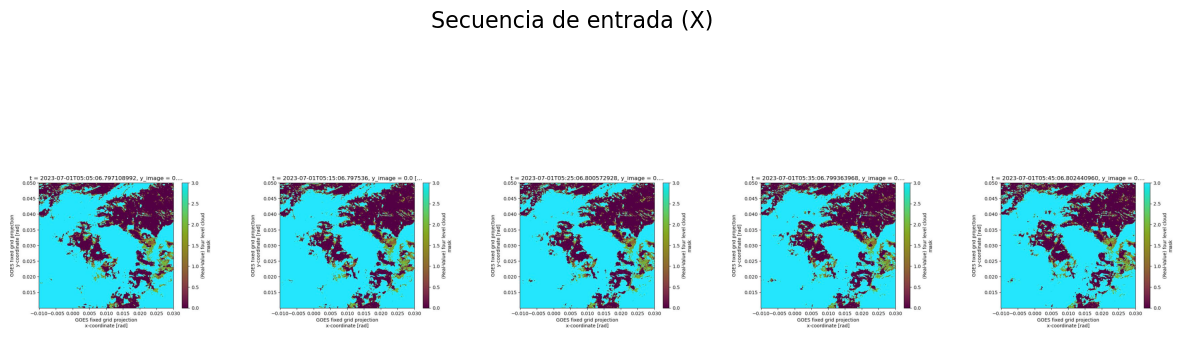

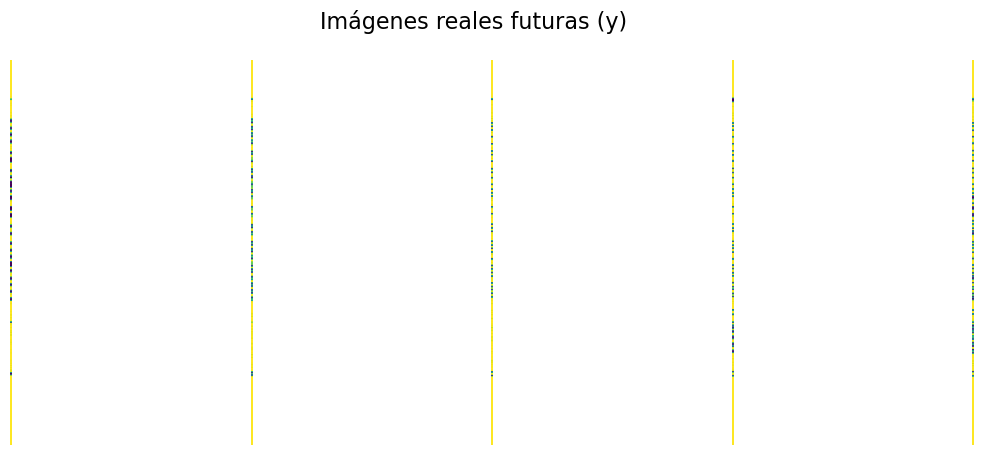

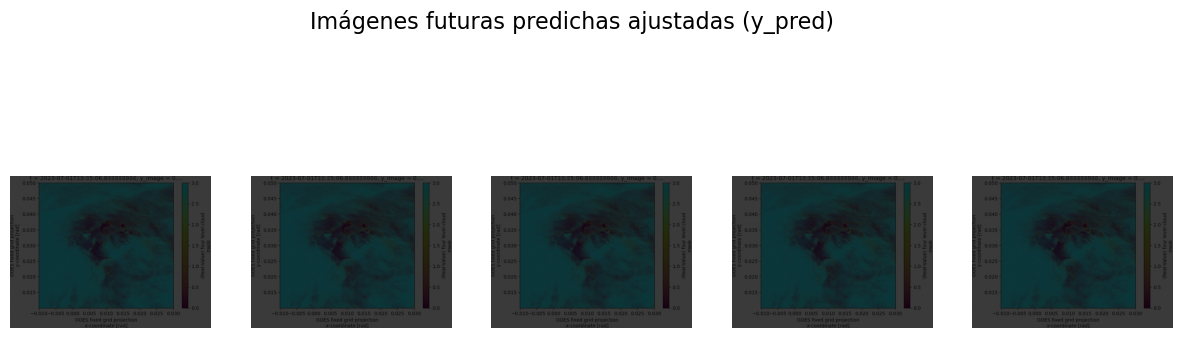

In [ ]:
# Importar librerías
import os
import cv2
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Función para redimensionar y normalizar imágenes de entrada (X)
def preprocess_input_images(image_sequences, target_height, target_width):
    preprocessed_sequences = []
    for sequence in image_sequences:
        processed_sequence = []
        for image in sequence:
            resized_image = cv2.resize(image, (target_width, target_height))  # Redimensionar
            normalized_image = resized_image / 255.0  # Normalizar entre 0 y 1
            processed_sequence.append(normalized_image)
        preprocessed_sequences.append(processed_sequence)
    return np.array(preprocessed_sequences)

# Configurar carpeta de imágenes
image_folder = "../data/Images_test" 
target_height, target_width, channels = 449, 593, 3  # Dimensiones deseadas para las imágenes


# Cargar imágenes
images = []
for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith(".jpg"):
        img = cv2.imread(os.path.join(image_folder, file_name))
        if img is None:
            print(f"Error cargando la imagen: {file_name}")
            continue
        resized_img = cv2.resize(img, (target_width, target_height))  # Redimensionar al tamaño deseado
        images.append(resized_img)

# Convertir la lista de imágenes a un array de NumPy
images = np.array(images)
print(f"Dimensiones de las imágenes cargadas: {images.shape}")

# Convertir a numpy array y crear secuencias
images = np.array(images)
sequence_length = 5  # Longitud de la secuencia
X = [images[i:i + sequence_length] for i in range(len(images) - sequence_length)]
y = [images[i + sequence_length] for i in range(len(images) - sequence_length)]

X = np.array(X)
y = np.array(y)

# Preprocesar imágenes de entrada
X_preprocessed = preprocess_input_images(X, target_height=64, target_width=64)

# Ajustar las etiquetas reales (y) para incluir la dimensión de la secuencia
y_original = np.expand_dims(y, axis=1)  # Agregar dimensión para la secuencia
y_original = np.repeat(y_original, sequence_length, axis=1)  # Replicar para que coincida con la salida
y_original = y_original / 255.0  # Normalizar entre 0 y 1

# Confirmar dimensiones
print(f"X_preprocessed shape: {X_preprocessed.shape}")
print(f"y_original shape: {y_original.shape}")

# Dimensiones originales de la imagen
original_height, original_width, channels = 449, 593, 3

# Modelo de extracción de características
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Definir el modelo
model = Sequential()
model.add(TimeDistributed(feature_extractor, input_shape=(sequence_length, 64, 64, 3)))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(sequence_length * original_height * original_width * channels, activation="linear"))
model.add(Reshape((sequence_length, original_height, original_width, channels)))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")

# Entrenar el modelo
history = model.fit(X_preprocessed, y_original, epochs=10, batch_size=16, verbose=1)

# Realizar predicciones
y_pred = model.predict(X_preprocessed)

# Ajustar rango de imágenes predichas y guardarlas
output_folder = "../data/Images_Forecast"
os.makedirs(output_folder, exist_ok=True)

for i, sequence in enumerate(y_pred):
    for j, image in enumerate(sequence):
        image_adjusted = np.clip(image * 255, 0, 255).astype(np.uint8)  # Ajustar brillo
        output_path = os.path.join(output_folder, f"prediction_{i}_step_{j}.jpg")
        cv2.imwrite(output_path, image_adjusted)

print(f"Imágenes ajustadas guardadas en: {output_folder}")

# Comparar diferencias entre predicciones
for i in range(len(y_pred) - 1):
    diff = np.abs(y_pred[i] - y_pred[i + 1])
    print(f"Diferencia promedio entre paso {i} y {i + 1}: {np.mean(diff)}")

# Medir variabilidad en las entradas
for i, sequence in enumerate(X_preprocessed):
    diff = np.abs(sequence[0] - sequence[-1])
    print(f"Variación promedio en la secuencia {i}: {np.mean(diff)}")

# Función para visualizar imágenes
def plot_images(images, title, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualizar resultados
plot_images(X[0], title="Secuencia de entrada (X)")
plot_images(y[0], title="Imágenes reales futuras (y)")
plot_images(y_pred[0], title="Imágenes futuras predichas ajustadas (y_pred)")


4/4 [==============================] - 4s 845ms/step
Imágenes ajustadas guardadas en: ../data/Images_Forecast
Diferencia promedio entre paso 0 y 1: 3.1402097988575406e-07
Diferencia promedio entre paso 1 y 2: 1.2133532436564565e-06
Diferencia promedio entre paso 2 y 3: 2.5546566462253395e-07
Diferencia promedio entre paso 3 y 4: 7.229078278214729e-07
Diferencia promedio entre paso 4 y 5: 2.7690617798725725e-07
Diferencia promedio entre paso 5 y 6: 5.005247203371255e-07
Diferencia promedio entre paso 6 y 7: 5.715883162338287e-07
Diferencia promedio entre paso 7 y 8: 1.5417096221881366e-07
Diferencia promedio entre paso 8 y 9: 4.599025942297885e-07
Diferencia promedio entre paso 9 y 10: 7.045939582894789e-07
Diferencia promedio entre paso 10 y 11: 5.51872346932214e-07
Diferencia promedio entre paso 11 y 12: 2.9923268130005454e-07
Diferencia promedio entre paso 12 y 13: 4.0408571067018784e-07
Diferencia promedio entre paso 13 y 14: 4.243812270487979e-07
Diferencia promedio entre paso 14 y

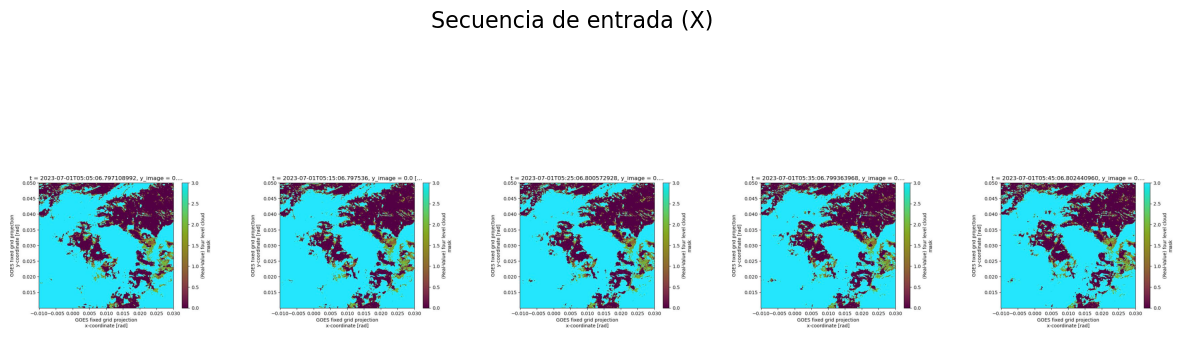

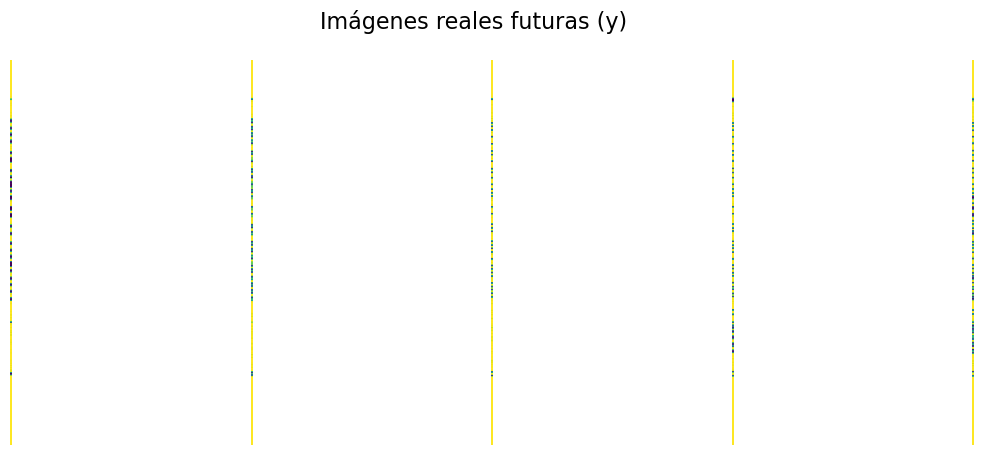

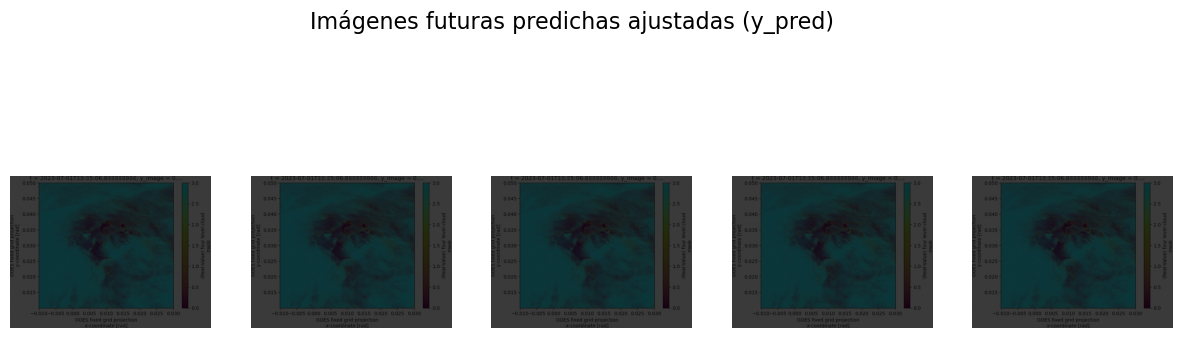

In [4]:
# Realizar predicciones
y_pred = model.predict(X_preprocessed)

# Ajustar rango de imágenes predichas y guardarlas
output_folder = "../data/Images_Forecast"
os.makedirs(output_folder, exist_ok=True)

for i, sequence in enumerate(y_pred):
    for j, image in enumerate(sequence):
        image_adjusted = np.clip(image * 255, 0, 255).astype(np.uint8)  # Ajustar brillo
        output_path = os.path.join(output_folder, f"prediction_{i}_step_{j}.jpg")
        cv2.imwrite(output_path, image_adjusted)

print(f"Imágenes ajustadas guardadas en: {output_folder}")

# Comparar diferencias entre predicciones
for i in range(len(y_pred) - 1):
    diff = np.abs(y_pred[i] - y_pred[i + 1])
    print(f"Diferencia promedio entre paso {i} y {i + 1}: {np.mean(diff)}")

# Medir variabilidad en las entradas
for i, sequence in enumerate(X_preprocessed):
    diff = np.abs(sequence[0] - sequence[-1])
    print(f"Variación promedio en la secuencia {i}: {np.mean(diff)}")

# Función para visualizar imágenes
def plot_images(images, title, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualizar resultados
plot_images(X[0], title="Secuencia de entrada (X)")
plot_images(y[0], title="Imágenes reales futuras (y)")
plot_images(y_pred[0], title="Imágenes futuras predichas ajustadas (y_pred)")
